In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "/mnt_home/bryanb/setigen/")
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [2]:
%matplotlib inline

In [3]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(raw_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

Blocks: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]     


In [4]:
!rawspec -f 1024 -t 4 -d . example_1block

working stem: example_1block
opening file: example_1block.0000.raw
opening file: example_1block.0001.raw [No such file or directory]
output product 0: 128 spectra


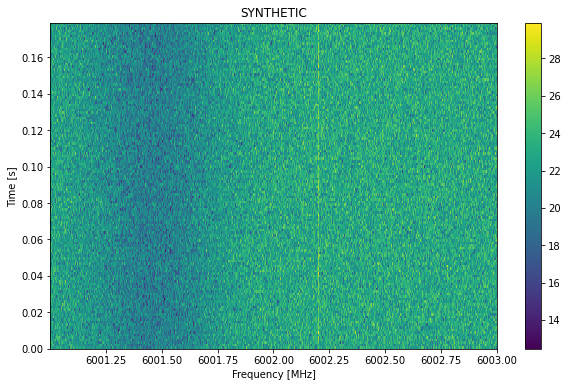

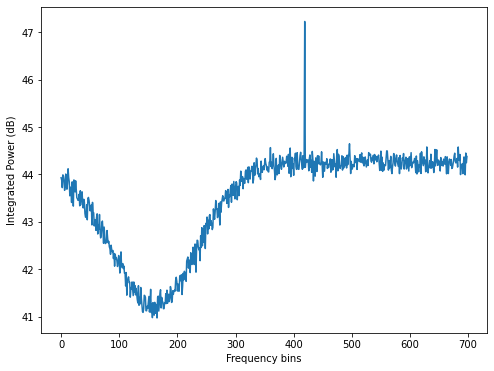

In [5]:
wf = bl.Waterfall('example_1block.rawspec.0000.fil',
                  f_start=6001.0,
                  f_stop=6003.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

x = stg.db(np.sum(wf.data[:, 0, :], axis=0))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

In [6]:
!ls

03_fine_channelization.ipynb	 raw_voltage_files.ipynb
coarse_chan_edges.ipynb		 raw_voltage_pipeline.ipynb
example_1block.0000.raw		 read_raw.ipynb
example_1block.rawspec.0000.fil  reduce_all.sh
fft_tests.py			 setigen_voltage_dev.ipynb
gen_alias.py			 Sim time series.ipynb
gen_array_raw.py		 test_0.0000.raw
gen_full5min.py			 test.0000.raw
gen_full5min_snr.py		 test_0.rawspec.0000.fil
gen_lower_sampling.py		 test_4bit.0000.raw
gen_raw.py			 test_4bit.rawspec.0000.fil
gen_snr_actual_5min.py		 test_alias.0000.raw
gen_snr_actual.py		 test_alias.rawspec.0000.fil
gen_snr_lightweight.py		 test.fil
gen_snr.py			 test_multiantenna.0000.raw
gen_snr_tutorial.ipynb		 test.raw
gen_snr_tutorial.py		 test.rawspec.0000.fil
header_template.txt		 test_snr_tutorial.rawspec.0000.fil
look_at_rawspec.ipynb		 Untitled.ipynb
rawspec				 view_filterbanks.ipynb


In [30]:
def get_header_key_val(header_line):
    """header_line as decoded string"""
    key = header_line[:8].strip()
    value = header_line[9:].strip().strip("''")
    return key, value

def read_header(raw_file_stem):
    first_file = f'{raw_file_stem}.0000.raw'
    
    header_dict = {}
    with open(first_file, "rb") as f:
        chunk = f.read(80)
        while f"{'END':<80}".encode() not in chunk:
            key, val = get_header_key_val(chunk.decode())
            header_dict[key] = val
            chunk = f.read(80)
    return header_dict

In [31]:
header = read_header('example_1block')
header

{'BACKEND': 'GUPPI   ',
 'TELESCOP': 'GBT     ',
 'OBSERVER': 'SETIGEN ',
 'PROJID': 'AGBT20B_999_22',
 'FRONTEND': 'RcvrArray18_26',
 'NRCVR': '2',
 'FD_POLN': 'CIRC    ',
 'BMAJ': '0.009263915095687008',
 'BMIN': '0.009263915095687008',
 'SRC_NAME': 'SYNTHETIC',
 'TRK_MODE': 'TRACK   ',
 'RA_STR': '04:41:45.7920',
 'RA': '70.4408',
 'DEC_STR': '+25:41:27.9600',
 'DEC': '25.6911',
 'LST': '83464',
 'AZ': '433.0963',
 'ZA': '69.1473',
 'DAQCTRL': 'start   ',
 'DAQPULSE': 'Tue Sep 22 00:24:27 2020',
 'DAQSTATE': 'record  ',
 'NBITS': '8',
 'OFFSET0': '0.0',
 'OFFSET1': '0.0',
 'OFFSET2': '0.0',
 'OFFSET3': '0.0',
 'BANKNAM': 'BLP00   ',
 'TFOLD': '0',
 'DS_FREQ': '1',
 'DS_TIME': '1',
 'FFTLEN': '512',
 'CHAN_BW': '2.9296875',
 'BANDNUM': '0',
 'NBIN': '0',
 'OBSNCHAN': '64',
 'SCALE0': '1.0',
 'SCALE1': '1.0',
 'DATAHOST': 'blr2-1-10-0.gb.nrao.edu',
 'SCALE3': '1.0',
 'NPOL': '4',
 'POL_TYPE': 'AABBCRCI',
 'BANKNUM': '0',
 'DATAPORT': '60000',
 'ONLY_I': '0',
 'CAL_DCYC': '0.5',
 'DIRE

In [10]:
keys = [
    'NBITS',
    'CHAN_BW',
    'NPOL',
    'BLOCSIZE',
    'SCANLEN',
    'TBIN',
#     'NANTS',
    'OBSNCHAN',
    'OBSFREQ',
    'OBSBW'
]
for key in keys:
    print(key, header[key])

NBITS 8
CHAN_BW 2.9296875
NPOL 4
BLOCSIZE 134217728
SCANLEN 0.17895697066666666
TBIN 3.41333333333333E-07
OBSNCHAN 64
OBSFREQ 6092.28515625
OBSBW 187.5


In [14]:
num_bits = int(header['NBITS'])
chan_bw = float(header['CHAN_BW']) * 1e6
num_pols = int(header['NPOL'])
if num_pols == 4:
    num_pols = 2
block_size = int(header['BLOCSIZE'])
obs_length = float(header['SCANLEN'])
tbin = float(header['TBIN'])
try:
    num_antennas = int(header['NANTS'])
except KeyError:
    num_antennas = 1
num_chans = int(header['OBSNCHAN']) // num_antennas
center_freq = float(header['OBSFREQ']) * 1e6

start_chan = 0
fch1 = center_freq - (start_chan + (num_chans - 1) / 2) * chan_bw
fch1

6000000000.0

In [23]:
def populate_pipeline_elements(raw_file_stem,
                               start_chan=0,
                               sample_rate=3e9):
    header = read_header(raw_file_stem)
    value_dict = {}
    
    
    value_dict['num_bits'] = int(header['NBITS'])
    value_dict['chan_bw'] = float(header['CHAN_BW']) * 1e6
    value_dict['ascending'] = (value_dict['chan_bw'] > 0)
    num_pols = int(header['NPOL'])
    if num_pols == 4:
        num_pols = 2
    value_dict['num_pols'] = num_pols
    value_dict['block_size'] = int(header['BLOCSIZE'])
    value_dict['obs_length'] = float(header['SCANLEN'])
    value_dict['tbin'] = float(header['TBIN'])
    try:
        num_antennas = int(header['NANTS'])
    except KeyError:
        num_antennas = 1
    value_dict['num_antennas'] = num_antennas
    value_dict['num_chans'] = int(header['OBSNCHAN']) // num_antennas
    value_dict['center_freq'] = float(header['OBSFREQ']) * 1e6

    value_dict['fch1'] = center_freq - (start_chan + (num_chans - 1) / 2) * chan_bw
    return value_dict
    
raw_params = populate_pipeline_elements('example_1block')
raw_params

{'num_bits': 8,
 'chan_bw': 2929687.5,
 'ascending': True,
 'num_pols': 2,
 'block_size': 134217728,
 'obs_length': 0.17895697066666666,
 'tbin': 3.41333333333333e-07,
 'num_antennas': 1,
 'num_chans': 64,
 'center_freq': 6092285156.25,
 'fch1': 6000000000.0}

## What might the code look like for reading in raw files as input

In [ ]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024
start_chan = 0

raw_params = populate_pipeline_elements('example_1block', start_chan=start_chan)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=raw_params['fch1'],
                              ascending=raw_params['ascending'],
                              num_pols=raw_params['num_pols'])

for stream in antenna.streams:
    stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=raw_params['num_bits'])

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=start_chan,
                                    num_chans=raw_params['num_chans'],
                                    block_size=raw_params['block_size'],
                                    blocks_per_file=128,
                                    num_subblocks=32,
                                    input_raw_file_stem='example_1block')

rvb.record(raw_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

In [28]:
!ls /datax/scratch/bbrzycki/data/raw_files/*raw

/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw
/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0013.raw
/datax/scratch/bbrzycki/data/raw_files/example_0.2s.0000.raw
/datax/scratch/bbrzycki/data/raw_files/example_1block.0000.raw
/datax/scratch/bbrzycki/data/raw_files/example_1s.0000.raw
/datax/scratch/bbrzycki/data/raw_files/example_multi.0000.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0000.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0001.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0002.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0003.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0004.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0005.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0006.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0007.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0008.raw
/datax/scratch/bbrzycki/data/raw_files/test_5min.0009.raw
/datax/scra

In [29]:
header

{'BACKEND': 'GUPPI   ',
 'TELESCOP': 'GBT     ',
 'OBSERVER': 'SETIGEN ',
 'PROJID': 'AGBT20B_999_22',
 'FRONTEND': 'RcvrArray18_26',
 'NRCVR': '2',
 'FD_POLN': 'CIRC    ',
 'BMAJ': '0.009263915095687008',
 'BMIN': '0.009263915095687008',
 'SRC_NAME': 'SYNTHETIC',
 'TRK_MODE': 'TRACK   ',
 'RA_STR': '04:41:45.7920',
 'RA': '70.4408',
 'DEC_STR': '+25:41:27.9600',
 'DEC': '25.6911',
 'LST': '83464',
 'AZ': '433.0963',
 'ZA': '69.1473',
 'DAQCTRL': 'start   ',
 'DAQPULSE': 'Tue Sep 22 00:24:27 2020',
 'DAQSTATE': 'record  ',
 'NBITS': '8',
 'OFFSET0': '0.0',
 'OFFSET1': '0.0',
 'OFFSET2': '0.0',
 'OFFSET3': '0.0',
 'BANKNAM': 'BLP00   ',
 'TFOLD': '0',
 'DS_FREQ': '1',
 'DS_TIME': '1',
 'FFTLEN': '512',
 'CHAN_BW': '2.9296875',
 'BANDNUM': '0',
 'NBIN': '0',
 'OBSNCHAN': '64',
 'SCALE0': '1.0',
 'SCALE1': '1.0',
 'DATAHOST': 'blr2-1-10-0.gb.nrao.edu',
 'SCALE3': '1.0',
 'NPOL': '4',
 'POL_TYPE': 'AABBCRCI',
 'BANKNUM': '0',
 'DATAPORT': '60000',
 'ONLY_I': '0',
 'CAL_DCYC': '0.5',
 'DIRE

In [ ]:
def read_header(raw_file_stem):
    first_file = f'{raw_file_stem}.0000.raw'
    
    header_dict = {}
    with open(first_file, "rb") as f:
        chunk = f.read(80)
        while f"{'END':<80}".encode() not in chunk:
            key, val = get_header_key_val(chunk.decode())
            header_dict[key] = val
            chunk = f.read(80)
    return header_dict

In [33]:
import glob

glob.glob('/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.????.raw')

['/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0000.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0001.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0002.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0003.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0004.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0005.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0006.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0007.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0008.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0009.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0010.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0011.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_lightweight.0012.raw',
 '/datax/scratch/bbrzycki/data/raw_files/test_snr_l

In [40]:
int(512 * np.ceil((80 * (len(header) + 1)) / 512))

6656

In [42]:
header['BLOCSIZE']

'134217728'

In [43]:
int(512 * np.ceil((80 * (len(header) + 1)) / 512)) + int(header['BLOCSIZE'])

134224384

In [49]:
134217728//16

8388608

In [6]:
def read_header(filename):
    header_dict = {}
    with open(filename, "rb") as f:
        chunk = f.read(80)
        while f"{'END':<80}".encode() not in chunk:
            key, val = get_header_key_val(chunk.decode())
            header_dict[key] = val
            chunk = f.read(80)
    return header_dict

def get_blocks_in_file(filename):
    
    header = read_header(filename)
#     print(header)
    with open(filename, "rb") as f:
        i = 0
        block_read_size = int(512 * np.ceil((80 * (len(header) + 1)) / 512)) + int(header['BLOCSIZE'])
        while f.read(block_read_size):
#             chunk = f.read(block_read_size)
#             if len(chunk) == 0:
#                 break
#             print(len(chunk))
            i += 1
    return i

def get_blocks_per_file(raw_file_stem):
    first_file = f'{raw_file_stem}.0000.raw'
    return blocks_in_file(first_file)

get_blocks_per_file('/datax/scratch/bbrzycki/data/raw_files/test_5min')

NameError: name 'blocks_in_file' is not defined

In [53]:
! ls -l /datax/scratch/bbrzycki/data/raw_files/test_5min.*.raw

-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 15 23:28 /datax/scratch/bbrzycki/data/raw_files/test_5min.0000.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 15 23:43 /datax/scratch/bbrzycki/data/raw_files/test_5min.0001.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 15 23:58 /datax/scratch/bbrzycki/data/raw_files/test_5min.0002.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 00:13 /datax/scratch/bbrzycki/data/raw_files/test_5min.0003.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 00:28 /datax/scratch/bbrzycki/data/raw_files/test_5min.0004.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 00:43 /datax/scratch/bbrzycki/data/raw_files/test_5min.0005.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 00:58 /datax/scratch/bbrzycki/data/raw_files/test_5min.0006.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 01:13 /datax/scratch/bbrzycki/data/raw_files/test_5min.0007.raw
-rw-rw-r-- 1 bryanb bryanb 17180721152 Feb 16 01:28 /datax/scratch/bbrzycki/data/raw_files/test_5min.0008.raw
-rw-rw-r--

In [66]:
def get_total_blocks(raw_file_stem):
    filenames = glob.glob(f'{raw_file_stem}.????.raw')
    blocks_per_file = get_blocks_per_file(raw_file_stem)
    if len(filenames) == 1:
        return blocks_per_file
    else:
        blocks_in_last_file = get_blocks_in_file(filenames[-1])
        return blocks_per_file * (len(filenames) - 1) + blocks_in_last_file

In [67]:
get_total_blocks('/datax/scratch/bbrzycki/data/raw_files/test_5min')

1676

In [68]:
'/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw'

'/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw'

In [9]:
def get_header_key_val(header_line):
    """header_line as decoded string"""
    key = header_line[:8].strip()
    value = header_line[9:].strip().strip("''")
    return key, value

def read_header(filename):
    header_dict = {}
    with open(filename, "rb") as f:
        chunk = f.read(80)
        while f"{'END':<80}".encode() not in chunk:
            key, val = get_header_key_val(chunk.decode())
            header_dict[key] = val
            chunk = f.read(80)
    return header_dict

def get_blocks_in_file(filename):
    
    header = read_header(filename)
#     print(header)
    with open(filename, "rb") as f:
        i = 0
        block_read_size = int(512 * np.ceil((80 * (len(header) + 1)) / 512)) + int(header['BLOCSIZE'])
        while f.read(block_read_size):
#             chunk = f.read(block_read_size)
#             if len(chunk) == 0:
#                 break
#             print(len(chunk))
            i += 1
    return i

def get_blocks_per_file(raw_file_stem):
    first_file = f'{raw_file_stem}.0000.raw'
    return get_blocks_in_file(first_file)

def get_dists(filename):
    header = read_header(filename)
    with open(filename, "rb") as f:
        i = 0
        header_size = int(512 * np.ceil((80 * (len(header) + 1)) / 512))
        f.read(header_size)
        
        block_size = int(header['BLOCSIZE'])
        chunk = f.read(block_size)

        try:
            num_antennas = int(header['NANTS'])
        except KeyError:
            num_antennas = 1
        num_chans = int(header['OBSNCHAN']) // num_antennas
        
        rawbuffer = np.frombuffer(chunk, dtype=np.int8).reshape((num_chans, -1))
        
        num_pols = int(header['NPOL'])
        if num_pols == 4:
            num_pols = 2
            
        for pol in range(num_pols):
            for comp in range(2):
                data = rawbuffer[:, comp+2*pol::2*num_pols]
                plt.hist(data.flatten(), bins=2**8)
                plt.show()
                fwhm_factor = 2 * np.sqrt(2 * np.log(2))
                mean = np.mean(data)
                std = np.std(data)
                print(f'Pol {pol}, comp {comp}: mean {mean}, std {std}, fwhm {std*fwhm_factor}')

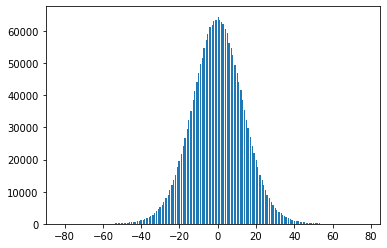

Pol 0, comp 0: mean 0.002410411834716797, std 13.59946696441858, fwhm 32.02429740954907


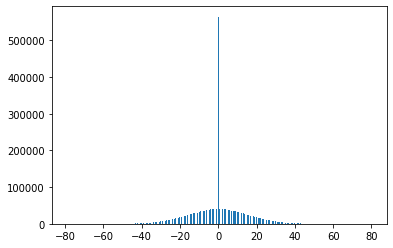

Pol 0, comp 1: mean -0.0018601417541503906, std 13.597464845201026, fwhm 32.01958277908303


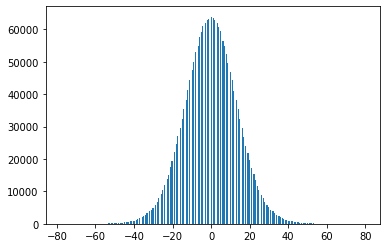

Pol 1, comp 0: mean -0.024530410766601562, std 13.586950808264872, fwhm 31.99482411415158


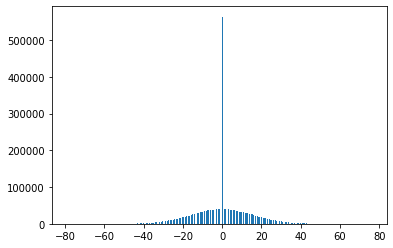

Pol 1, comp 1: mean -0.03543424606323242, std 13.593832850512747, fwhm 32.01103008518763


In [86]:
get_dists('/datax/scratch/bbrzycki/data/raw_files/test_snr_tutorial.0000.raw')

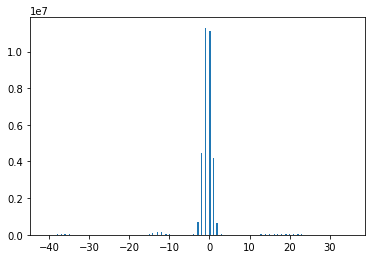

Pol 0, comp 0: mean -0.7102513611316681, std 3.6968826967448356, fwhm 8.705493478422811


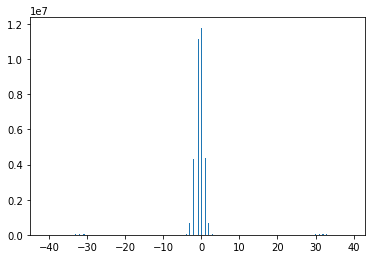

Pol 0, comp 1: mean -0.48728644847869873, std 3.36669266133621, fwhm 7.9279553643731004


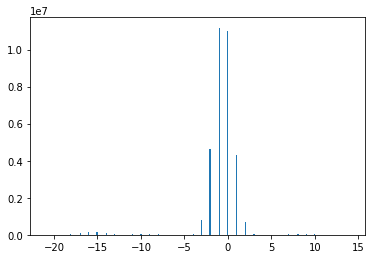

Pol 1, comp 0: mean -0.755323976278305, std 2.317930800001436, fwhm 5.458309910838006


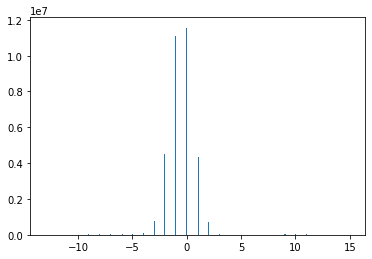

Pol 1, comp 1: mean -0.501361072063446, std 1.3983090287323152, fwhm 3.2927661300066133


In [87]:
get_dists('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0000.raw')

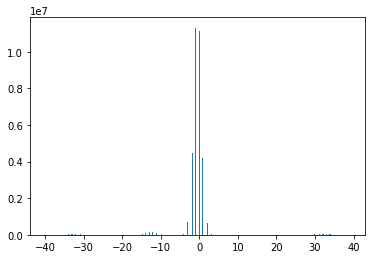

Pol 0, comp 0: mean -0.7089943587779999, std 3.689883181212276, fwhm 8.689010878941234


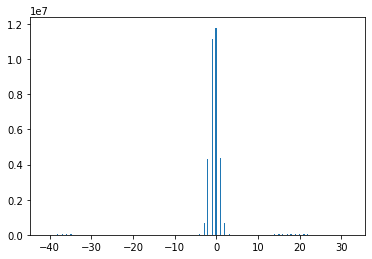

Pol 0, comp 1: mean -0.48717716336250305, std 3.3661828934722577, fwhm 7.9267549527887535


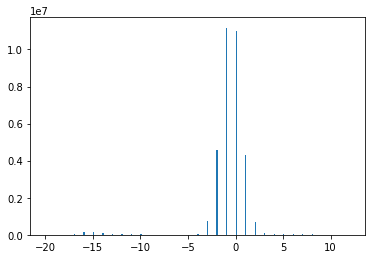

Pol 1, comp 0: mean -0.7531783580780029, std 2.299580252705652, fwhm 5.415097674228606


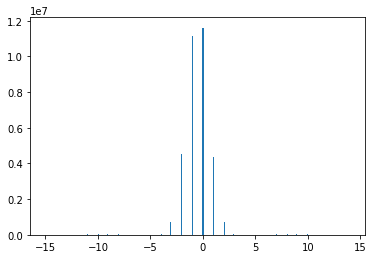

Pol 1, comp 1: mean -0.5011814534664154, std 1.3966597564436183, fwhm 3.288882390561476


In [88]:
get_dists('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.0013.raw')

In [82]:
plt.hist

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)>

In [10]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(raw_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

Blocks: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]     


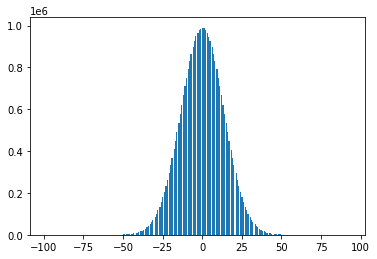

Pol 0, comp 0: mean 0.000353395938873291, std 13.59197649053546, fwhm 32.00665869150232


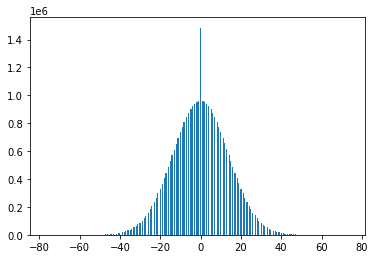

Pol 0, comp 1: mean 0.002428978681564331, std 13.591747580438764, fwhm 32.0061196494181


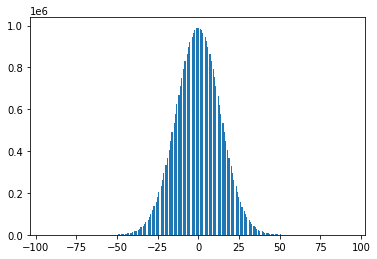

Pol 1, comp 0: mean 0.0007267296314239502, std 13.589426470404426, fwhm 32.00065385298252


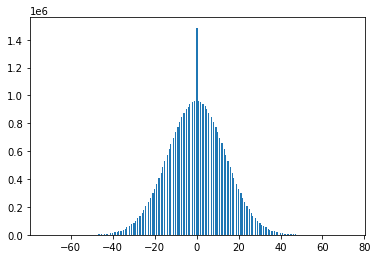

Pol 1, comp 1: mean -0.0017045438289642334, std 13.591150174975272, fwhm 32.00471286705766


In [11]:
get_dists('example_1block.0000.raw')

Blocks: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]     


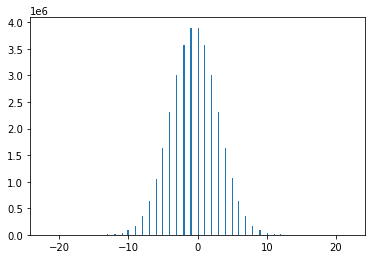

Pol 0, comp 0: mean -0.49937164783477783, std 3.4093680186416733, fwhm 8.028448151184863


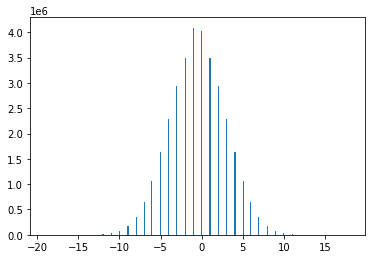

Pol 0, comp 1: mean -0.5018437504768372, std 3.4100712503827957, fwhm 8.03010413538516


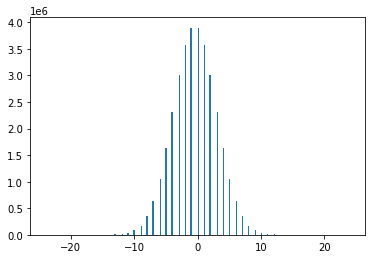

Pol 1, comp 0: mean -0.49948087334632874, std 3.4103469400187, fwhm 8.030753334865995


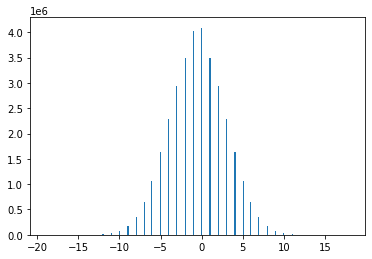

Pol 1, comp 1: mean -0.4995076358318329, std 3.4097307421077145, fwhm 8.029302299673502


In [13]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

for stream in antenna.streams:
    stream.add_noise(0, 1)
    stream.add_constant_signal(f_start=6002.2e6, 
                               drift_rate=-2,
                               level=0.002,
                               phase=0)
    
digitizer = stg.voltage.RealQuantizer(target_mean=0, 
                                      target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_mean=-0.5,
                                           target_fwhm=8,
                                           num_bits=8)

rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

rvb.record(raw_file_stem='example_1block',
           num_blocks=1, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

get_dists('example_1block.0000.raw')

In [2]:
16//4

4